In [156]:
# imports
import pandas as pd
from sklearn import linear_model, preprocessing
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import networkx as nx
from networkx.algorithms import approximation

Reading and Cleaning


In [157]:
raw_data = pd.read_sas("data/merged_df.sas7bdat")
raw_data["PRC"] = abs(raw_data["PRC"])
raw_data = raw_data.sort_values(["permno", "monthid"])
raw_data["year"] = raw_data["yyyymm"] / 100
raw_data["month"] = raw_data["yyyymm"] % 100

raw_data.dropna(subset= ['ticker', 'conm', 'gvkey', 'cusip', 'naics', 'gsubind'], inplace = True)

factor_names = np.array(['range_20', 'log_vol_dollar_20',
       'range_120', 'log_vol_dollar_120', 'xret_5', 'xret_10', 'xret_20',
       'xret_indsize_20', 'xret_indsize_std20', 'xret_40', 'xret_120',
       'xret_indsize_120', 'xret_indsize_std120', 'KDJ_20', 'deviation_pct20',
       'MoneyFlowIndex_20', 'RSI_20', 'KDJ_120', 'deviation_pct120',
       'MoneyFlowIndex_120', 'RSI_120', 'IV_capm', 'mdr', 'ami_3', 'beta_3y',
       'beta_5y', 'BL', 'roe', 'roa',
       'profitability', 'sales_g_q', 'sales_g_ttm', 'op_income_g_q', 'ni_g_q',
       'op_income_g_ttm', 'ni_g_ttm', 'sue_NI', 'BM', 'AM', 'EP', 'SP',
       'roe_q', 'roa_q', 'Cto', 'lag_log_size'])

In [158]:
temp = raw_data["gvkey"].str.decode('utf-8')
temp = temp.unique()
temp = pd.DataFrame(temp)
temp.to_csv('names.csv')

In [159]:
factor_data = pd.read_sas('factor_data.sas7bdat', encoding="ISO-8859-1")

# Question 2.

In [160]:
# Question 2 Filtering Dataset
raw_data = raw_data.groupby(["permno", "year"]).filter(lambda group: (group.iloc[0]["PRC"] >= 5) & (group.iloc[0]["PRC"] * group.iloc[0]["SHROUT"] >= 100000)).reset_index()

In [161]:
raw_data['permno'] = raw_data['permno'].astype(np.int64)
raw_data["gvkey"] = raw_data["gvkey"].str.decode('utf-8') 

In [162]:
factor_data['date'] = factor_data['DATADATE'].dt.strftime('%Y%m')
factor_data ['date']= factor_data['date'].astype(float)
factor_data.head()

GVKEY   DATADATE  FYEARQ  FQTR  ACTQ  ATQ   CEQQ  CHEQ  CHQ  COGSQ   DLCQ  \
0  001004 1968-08-31  1968.0   1.0   NaN  NaN    NaN   NaN  NaN    NaN    NaN   
1  001004 1968-11-30  1968.0   2.0   NaN  NaN    NaN   NaN  NaN    NaN    NaN   
2  001004 1969-02-28  1968.0   3.0   NaN  NaN    NaN   NaN  NaN    NaN    NaN   
3  001004 1969-05-31  1968.0   4.0   NaN  NaN  4.744   NaN  NaN  7.298  0.198   
4  001004 1969-08-31  1969.0   1.0   NaN  NaN    NaN   NaN  NaN    NaN    NaN   

   DLTTQ    DPQ  FINDLCQ  IVAOQ  IVSTQ  LCTQ  LTQ  MIBQ    NIQ  OIADPQ    PIQ  \
0    NaN    NaN      NaN    NaN    NaN   NaN  NaN   NaN  0.080     NaN  0.165   
1    NaN    NaN      NaN    NaN    NaN   NaN  NaN   NaN  0.079     NaN  0.167   
2    NaN    NaN      NaN    NaN    NaN   NaN  NaN   NaN    NaN     NaN    NaN   
3  1.637  0.183      NaN    NaN    NaN   NaN  NaN   NaN  0.195   0.816  0.393   
4    NaN    NaN      NaN    NaN    NaN   NaN  NaN   NaN  0.116     NaN  0.220   

   PSTKQ  PSTKRQ  REVTQ  SALEQ  COGSY  DPY  FOPTY  PRSTKCY  REVTY  SSTKY  \
0    NaN     NaN  1.694  1.694    NaN  NaN    NaN      NaN  1.694    NaN   
1    NaN     NaN  2.098  2.098    NaN  NaN    NaN      NaN    NaN    NaN   
2    NaN     NaN    NaN    NaN    NaN  NaN    NaN      NaN    NaN    NaN   
3    0.0     NaN  6.164  6.164    NaN  NaN    NaN      NaN    NaN    NaN   
4    NaN     NaN  4.166  4.166    NaN  NaN    NaN      NaN  4.166    NaN   

  CONSOL INDFMT DATAFMT POPSRC DATAFQTR DATACQTR CURCDQ COSTAT      date  
0      C   INDL     STD      D   1968Q1   1968Q3    USD      A  196808.0  
1      C   INDL     STD      D   1968Q2   1968Q4    USD      A  196811.0  
2      C   INDL     STD      D   1968Q3   1969Q1    USD      A  196902.0  
3      C   INDL     STD      D   1968Q4   1969Q2    USD      A  196905.0  
4      C   INDL     STD      D   1969Q1   1969Q3    USD      A  196908.0

In [163]:
pd.set_option('display.max_columns', None)

In [164]:
# df_merged = raw_data.merge(factor_data, how= 'left', left_on= ['gvkey', 'yyyymm'], right_on= ['GVKEY', 'date'])

# factor_new = list(df_merged.columns[-39:])
# df_merged[['gvkey'] + factor_new] = df_merged.groupby('gvkey')[factor_new].ffill().fillna(0).reset_index()
# df_merged

df_merged = raw_data.merge(factor_data, how= 'left', left_on= ['gvkey', 'yyyymm'], right_on= ['GVKEY', 'date'])

factor_new = factor_data.columns[3:-1]
df_merged[np.append(['gvkey'], factor_new)] = df_merged.groupby('gvkey')[factor_new].ffill().fillna(0).reset_index()
df_merged["REVTQ"] = df_merged["REVTQ"].replace(0, np.NaN)
df_merged.dropna(subset=["REVTQ"], inplace=True)

Creating new factors

In [165]:
df_merged['mv'] = abs(df_merged['PRC'])*df_merged['SHROUT']

In [166]:
#Rolling earnings growth
df_merged['earn_grow_roll'] = df_merged.groupby('permno')['ni_g_ttm'].rolling(window = 12, min_periods = 9).mean().reset_index(drop=True)
#rolling div yield
df_merged['div_roll'] = df_merged.groupby('permno')['dp'].rolling(window = 12, min_periods = 9).mean().reset_index(drop=True)

In [167]:
#Gross Profit / Asset
df_merged['gpa'] = (df_merged['REVTQ'] - df_merged['COGSQ'])/df_merged['ATQ']

#rolling 12 month realized volatility
df_merged['log_ret_sq'] = np.log(abs(1 + df_merged['RET']))**2
df_merged['realize_vol'] = df_merged.groupby('permno')['log_ret_sq'].rolling(12, min_periods = 9).apply(lambda x: np.sqrt(sum(x))).reset_index(0,drop=True)


In [168]:
#Net Payout Factor
df_merged['nop'] = (df_merged['dp'] + df_merged['PRSTKCY'] +df_merged['PSTKRQ'] - df_merged ['SSTKY'])/df_merged['mv']

In [169]:
#Accrual Volatility Factor
df_merged['nwcc'] = ((df_merged['ACTQ'] - df_merged['CHEQ']) - (df_merged['LCTQ'] - df_merged['DLCQ']))
df_merged['nwcc_chg'] = df_merged.groupby('permno')['nwcc'].diff().reset_index(0,drop=True)
df_merged['ac_sale'] = (df_merged['nwcc_chg'] - df_merged['DPQ'])/df_merged['SALEQ']
df_merged['accv'] = df_merged.groupby('permno')['ac_sale'].rolling(64, min_periods = 32).std().reset_index(0, drop = True)

In [170]:
#Operating Factors
df_merged['NOA'] = (df_merged['ATQ'] - df_merged['CHEQ']) - (df_merged['ATQ'] - df_merged['DLCQ'] - df_merged['DLTTQ'] - df_merged['MIBQ'] - df_merged['PSTKQ'] - df_merged['CEQQ'])
df_merged['NOA_shift'] = df_merged.groupby('permno')['NOA'].shift(1)
df_merged['ATO'] = df_merged['NOA_shift']/df_merged['REVTQ']

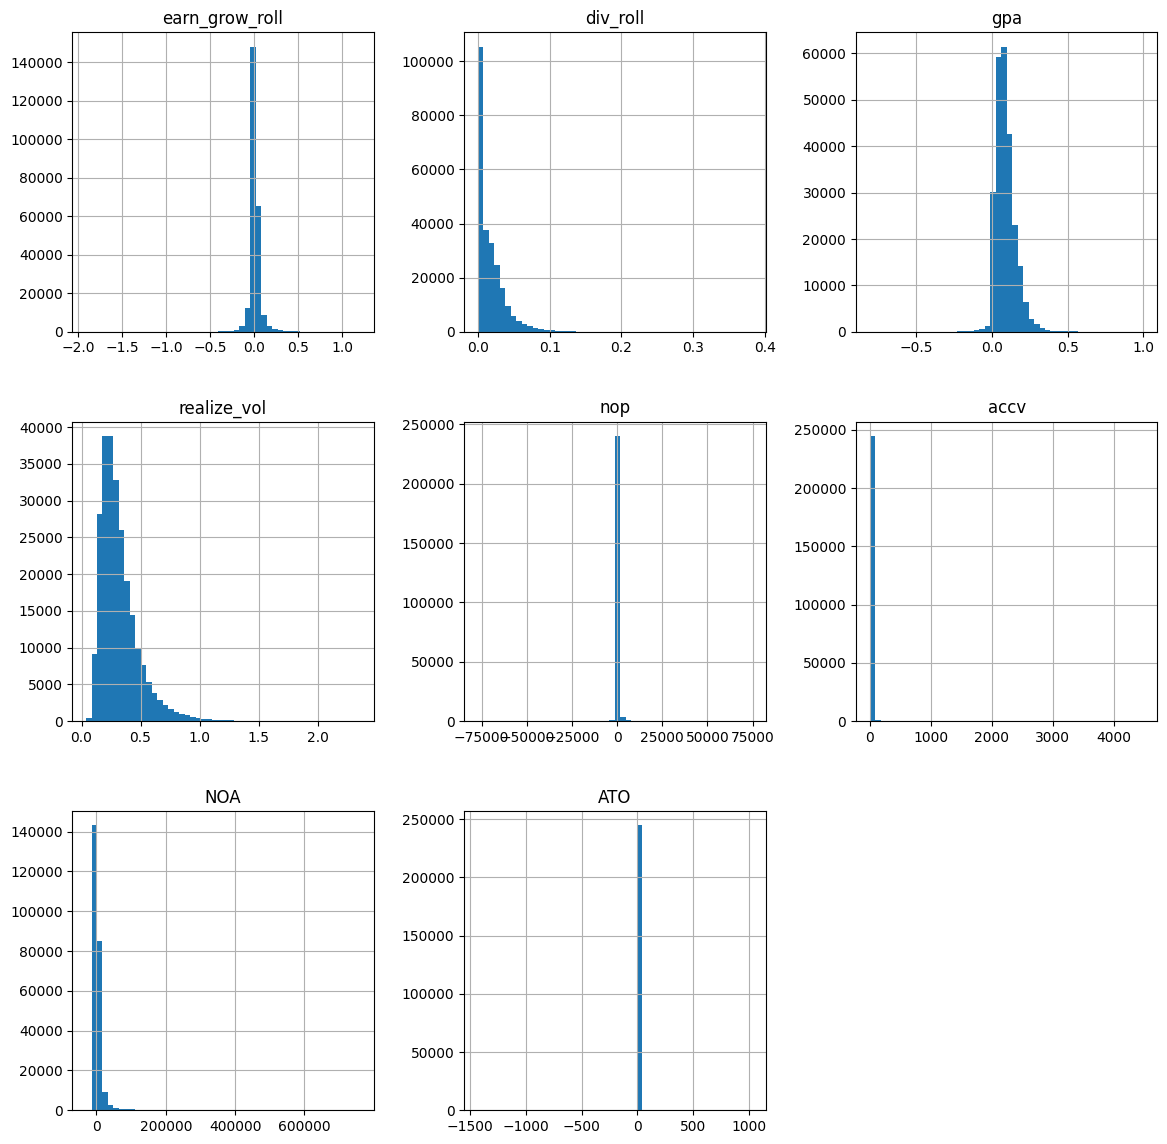

In [171]:
#Visuallizing new factors
new_fac = ['earn_grow_roll', 'div_roll', 'gpa', 'realize_vol', 'nop', 'accv', 'NOA', 'ATO']
factor_names = np.unique(np.append(factor_names, new_fac))
df_merged[new_fac].dropna().hist(bins=50, figsize=(14,14))
plt.show()

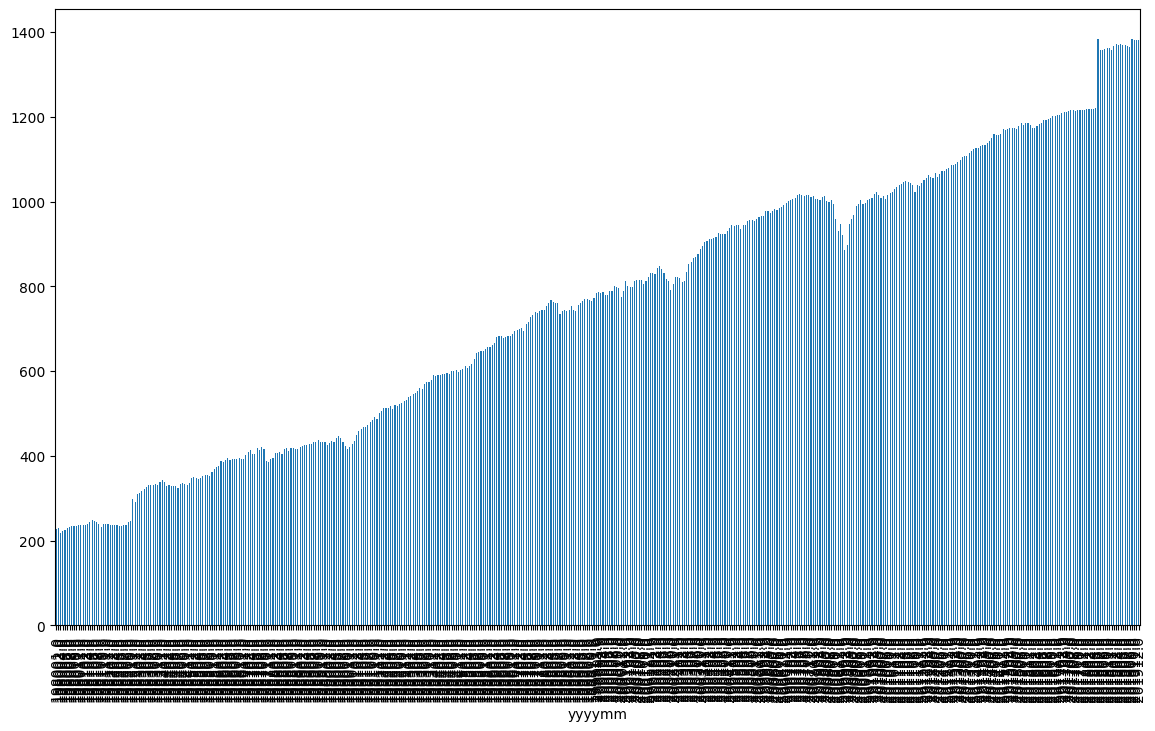

In [172]:
raw_data.groupby('yyyymm').count()['permno'].plot(kind='bar', figsize=(14, 8))
plt.show()

# Standardize and Winsorize

In [173]:
# impute missing factor values
def imputeGroup(group):
    global factor_names
    
    for factor in factor_names:
        movingMedian = group[factor].rolling(window=5, min_periods = 1).median()
        group[factor] = group[factor].fillna(movingMedian)
    
    return group
    
imputed_data = df_merged.groupby("permno", group_keys=False).apply(imputeGroup)
imputed_data = imputed_data.dropna(subset=factor_names)

In [174]:
# z scores
def standardizeGroup(group):
    global factor_names
    
    group[factor_names] = preprocessing.MinMaxScaler().fit_transform(group[factor_names].values)
    
    return group

data_standardized = imputed_data.groupby(["monthid"], group_keys=False).apply(standardizeGroup)

In [175]:
 # winsorize raw factor values

def winsorizeGroup(group):
    if len(group) < 2:
        return None
    global factor_names
    upper = group[factor_names].std() * 3
    lower = -upper
    group[factor_names] = group[factor_names].clip(lower, upper, axis="columns")
    
    return group

cleaned_data = data_standardized.groupby(["monthid"], group_keys=False).apply(winsorizeGroup)

# EDA

Creating Correlation Matrix


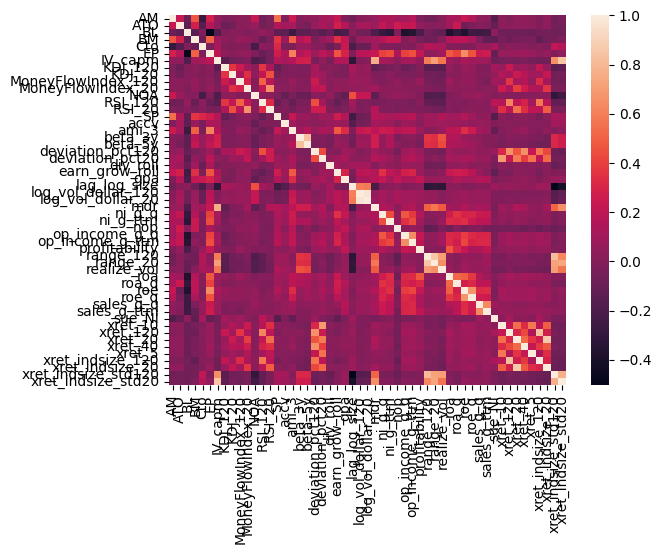

In [176]:
factor_corr_matrix = cleaned_data[factor_names].corr()
sns.heatmap(factor_corr_matrix, 
        xticklabels=factor_corr_matrix.columns,
        yticklabels=factor_corr_matrix.columns)
plt.show()

In [177]:
# compute correlation matrix of factors

# convert to upper triangular (corr matrix is symmetric)
upper_factor_corr_matrix = factor_corr_matrix.where(~np.tril(np.ones(factor_corr_matrix.shape)).astype(bool))

# melt into factor pairs and corr between the pair
factor_corr_pairs = upper_factor_corr_matrix.stack().reset_index()
factor_corr_pairs.columns = ["factor1", "factor2", "corr"]

# filter for pairs with corr > 0.7
factor_corr_pairs = factor_corr_pairs[abs(factor_corr_pairs["corr"]) > 0.7]

# create graph
vertex_set = np.unique(np.append(factor_corr_pairs["factor1"], factor_corr_pairs["factor2"]))

# add factor names here if you want to protect it from being dropped in this step (just make sure there is no pairwise colinearity between protected factors)
protected_vertices = new_fac

graph = nx.Graph()
graph.add_nodes_from(np.array([(vertex, {"weight": np.inf if vertex in protected_vertices else 1}) for vertex in vertex_set]))
graph.add_edges_from(factor_corr_pairs[["factor1", "factor2"]].values.tolist())

colinear_cover = list(approximation.min_weighted_vertex_cover(graph, "weight"))

# drop the cover from factor_returns

factor_data_non_colinear = cleaned_data.drop(colinear_cover, axis="columns")
factor_names_non_colinear = np.setdiff1d(factor_names, colinear_cover)

Performance Function


In [178]:
# compute factor returns

# get dataframe with just the factor data (easier to work with)
factor_data = cleaned_data[np.append(['permno', 'monthid', 'RET'], factor_names_non_colinear)]

factor_returns = pd.DataFrame(columns = np.append(["monthid"], [s + "_ret" for s in factor_names_non_colinear]))


def calcDecileReturns(group):
    # takes a group of stocks in a month, computes decile 10 - decile 1
    global factor_names_non_colinear, factor_returns
    bins = 10
    row = np.array([group.name])
    
    # for each factor, call qcut
    for factor in factor_names_non_colinear:
        #deciles = pd.qcut(group[factor], bins, labels=False)
        first_ret = group.loc[group[factor] <= group[factor].quantile(0.1)]["RET"].mean()
        tenth_ret = group.loc[group[factor] >= group[factor].quantile(0.9)]["RET"].mean()
        decile_return = tenth_ret - first_ret
        row = np.append(row, [decile_return])
    
    factor_returns.loc[len(factor_returns)] = row


factor_data.dropna().groupby("monthid").apply(calcDecileReturns)
factor_returns = factor_returns[factor_returns["monthid"] != 33]

In [179]:
# fama macbeth regressions
cross_sectional_betas = factor_data_non_colinear.groupby("monthid").apply(lambda g: sm.OLS(g["ret_f1"], sm.add_constant(g[factor_names_non_colinear]), missing="drop").fit().params).reset_index()
#cross_sectional_betas = cross_sectional_betas.pivot(columns="level_1", values=0, index="monthid")
cross_sectional_betas_mean = cross_sectional_betas.mean()

fama_macbeth_tstats = pd.DataFrame(columns = factor_names_non_colinear)
fama_macbeth_tstats.loc[0] = np.zeros_like(factor_names_non_colinear)

for factor in factor_names_non_colinear:
    fama_macbeth_tstats[factor].loc[0] = abs(stats.ttest_1samp(cross_sectional_betas[factor], 0).statistic.round(4))

### Elastic net regression


In [180]:
fama_macbeth_factor = np.unique(np.append(np.array(fama_macbeth_tstats.iloc[0][fama_macbeth_tstats.iloc[0] > 1.9].index), new_fac))
fama_macbeth_factor

array(['ATO', 'NOA', 'accv', 'div_roll', 'earn_grow_roll', 'gpa',
       'lag_log_size', 'nop', 'profitability', 'realize_vol', 'sales_g_q',
       'sue_NI'], dtype=object)

In [181]:
train_df = cleaned_data.merge(factor_returns, on="monthid", how="inner")
training_factor_names = [s + "_ret" for s in fama_macbeth_factor]
training_factor_names

['ATO_ret',
 'NOA_ret',
 'accv_ret',
 'div_roll_ret',
 'earn_grow_roll_ret',
 'gpa_ret',
 'lag_log_size_ret',
 'nop_ret',
 'profitability_ret',
 'realize_vol_ret',
 'sales_g_q_ret',
 'sue_NI_ret']

### Model Validation

In [182]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# validation function
def validate_model(model_type, param_grid, x_train, y_train, x_validate, y_validate):
    # Special case for LinearRegression because it doesn't have hyperparameters to tune
    if model_type == LinearRegression:
        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_validate)
        r2 = r2_score(y_validate, pred)
        
        return r2
    else: # The other cases
        
        # Establishses the ParameterGrid
        model_param_grid = ParameterGrid(param_grid)
        
        # Initialize values
        best_MAE = 0
        best_r2 = 1
        best_config = None
        # Iterate through the parameter grid, fit models to the hyperparameters
        # and check for MAE and R2 values
        
        # each param_config in that validation function would represent 1 combination of the possible parameters.
        # for example in Lab 6, when I'm validating for the elastic net regression, I have 
        # 2 possible hyperparameters: alpha and l1_ratio. 
        #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
        #So each param_config in the for loop in validate_model would go over 1 possible 
        #combination of the hyperparameter and keep the one that gives us the best MAE/R2
        for param_config in model_param_grid:
            curr_config_MAEs = []
            model = model_type(**param_config)
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            curr_config_MAEs.append(MAE)
            if best_MAE == 0 or (MAE < best_MAE):
                best_MAE = MAE
                best_config = param_config
            if best_r2 == 1 or (r2 > best_r2):
                best_r2 = r2
        return best_config, best_MAE, best_r2

In [183]:
def validate_model_print(model, data, permno, factor_names):
    x_train = data[(data['yyyymm'] <= 200312)][factor_names]
    y_train = data[data['yyyymm'] <= 200312]["ret_f1"]

    if (len(x_train) == 0): 
        print('Stock permno: ' + str(permno) + ' No training data')
        return

    x_validate = data[(data['yyyymm'] > 200312) & (data['yyyymm'] <= 201112)][factor_names]
    y_validate = data[(data['yyyymm'] > 200312) & (data['yyyymm'] <= 201112)]["ret_f1"]

    if (len(x_validate) == 0): 
        print('Stock permno: ' + str(permno) + ' No validation data')
        return

    en_grid = dict()
    # Set the parameter grid
    en_grid['alpha'] = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
    en_grid['l1_ratio'] = np.arange(0, 1, 0.01)

    en_best_config, en_best_MAE, en_best_r2 = validate_model(model, en_grid, x_train, y_train, x_validate, y_validate)

    return (en_best_config, en_best_MAE, en_best_r2)

In [184]:
from sklearn.linear_model import ElasticNet

def RunStockRegression(train_df, train_factor_names):
    df = train_df.groupby("permno").apply(lambda g: validate_model_print(ElasticNet, g, g.name, train_factor_names))
    return df

In [185]:
train_df['ret_f1'].isna().sum()
train_df.dropna(subset=['ret_f1'], inplace=True)
train_df[['permno', 'yyyymm', 'ret_f1']]

permno    yyyymm    ret_f1
0        10026  199402.0 -0.130719
1        10104  199402.0 -0.026515
2        10107  199402.0  0.027273
3        10138  199402.0 -0.099840
4        10145  199402.0 -0.044190
...        ...       ...       ...
239759   49373  198208.0 -0.008438
239760   55976  198208.0  0.131474
239761   60097  198208.0 -0.069364
239762   60871  198208.0 -0.062857
239763   61399  198208.0  0.006329

[239728 rows x 3 columns]

In [186]:
import warnings
warnings.filterwarnings('ignore')

# Run the validation
regress_df = RunStockRegression(train_df, training_factor_names)
regress_df.head()

Stock permno: 10120 No validation data
Stock permno: 10241 No validation data
Stock permno: 10318 No training data
Stock permno: 10460 No validation data
Stock permno: 11144 No training data
Stock permno: 11174 No training data
Stock permno: 11481 No training data
Stock permno: 11664 No training data
Stock permno: 11936 No validation data
Stock permno: 11997 No validation data
Stock permno: 12095 No validation data
Stock permno: 12308 No training data
Stock permno: 12363 No training data
Stock permno: 12431 No validation data
Stock permno: 12449 No training data
Stock permno: 12473 No training data
Stock permno: 12477 No training data
Stock permno: 12558 No training data
Stock permno: 12583 No training data
Stock permno: 12588 No training data
Stock permno: 12615 No training data
Stock permno: 12622 No training data
Stock permno: 12623 No training data
Stock permno: 12758 No training data
Stock permno: 12872 No training data
Stock permno: 12880 No training data
Stock permno: 12905 No t

permno
10026    ({'alpha': 0.001, 'l1_ratio': 0.51}, 0.0056171...
10032    ({'alpha': 0.005, 'l1_ratio': 0.0}, 0.01987762...
10051    ({'alpha': 0.005, 'l1_ratio': 0.46}, 0.0216812...
10104    ({'alpha': 0.0005, 'l1_ratio': 0.99}, 0.006233...
10107    ({'alpha': 0.0005, 'l1_ratio': 0.39}, 0.005256...
dtype: object

In [187]:
regress_df_save = regress_df.copy()

In [188]:
test_list = [t for t in regress_df]
regress_df = pd.DataFrame(test_list, columns=['best_config', 'best_MAE', 'best_r2'])
sorted_permno = train_df['permno'].unique()
sorted_permno.sort()
regress_df['permno'] = sorted_permno
regress_df.dropna(inplace=True)
display(regress_df)

best_config  best_MAE   best_r2  \
0                  {'alpha': 0.001, 'l1_ratio': 0.51}  0.005617 -0.005016   
1                   {'alpha': 0.005, 'l1_ratio': 0.0}  0.019878  0.012246   
2                  {'alpha': 0.005, 'l1_ratio': 0.46}  0.021681 -0.127832   
3                 {'alpha': 0.0005, 'l1_ratio': 0.99}  0.006233 -0.069685   
4                 {'alpha': 0.0005, 'l1_ratio': 0.39}  0.005256 -0.083841   
..                                                ...       ...       ...   
992                {'alpha': 0.001, 'l1_ratio': 0.68}  0.009162  0.000027   
993                   {'alpha': 0.1, 'l1_ratio': 0.0}  0.025257 -0.001861   
997  {'alpha': 0.005, 'l1_ratio': 0.5700000000000001}  0.010095 -0.147418   
998  {'alpha': 0.001, 'l1_ratio': 0.7000000000000001}  0.029266 -0.189089   
999                {'alpha': 0.005, 'l1_ratio': 0.51}  0.024273 -0.008777   

     permno  
0     10026  
1     10032  
2     10051  
3     10104  
4     10107  
..      ...  
992   88152  
993   88159  
997   88281  
998   88319  
999   88352  

[720 rows x 4 columns]

### Model testing and model statistics

In [189]:
rf_month = pd.read_sas("data/ff_factors_monthly.sas7bdat")
rf_month['yyyymm'] = pd.to_datetime(rf_month['dateff']).dt.year * 100 + pd.to_datetime(rf_month['dateff']).dt.month

In [190]:
# Predictions
coef_df = pd.DataFrame()

def pred(model_type, x_train, y_train, x_test, param_config):
    # Fit model and predict
    global coef_df
    
    model = model_type(**param_config)

    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['RET_pred'])
    x_test.reset_index(drop=False, inplace=True)
    pred_df['yyyymm'] = x_test['yyyymm']
    # display(pred_df.head())

    # Calculate betas from the model
    if (model_type == ElasticNet):
        betas = model.coef_
        coef_dict = dict(zip(x_train.columns, betas))
        coef_dict['alpha'] = model.alpha
        coef_dict['l1_ratio'] = model.l1_ratio
        coef_df = coef_df.append(coef_dict, ignore_index=True)

    # r2 = r2_score(y_test, pred)
    return pred_df

In [191]:
def stock_pred_apply(test_data, factor_names):
    config = test_data['best_config'].values[0]

    x_train = test_data[test_data['yyyymm'] <= 200312][factor_names]
    y_train = test_data[test_data['yyyymm'] <= 200312]["ret_f1"]

    x_test = test_data[test_data['yyyymm'] > 201112][factor_names]
    if (len(x_test) == 0): 
        print('Stock permno: ' + str(test_data['permno'].values[0]))
        print('No training data')
        return
    x_test['yyyymm'] = test_data[test_data['yyyymm'] > 201112]['yyyymm']
    x_test.set_index('yyyymm', inplace=True)

    return pred(ElasticNet, x_train, y_train, x_test, config)

def stock_pred(regress_df, data, factor_names):
    unique_permno = regress_df['permno'].unique()
    unique_permno.sort()

    test_data = data.drop(data[~data['permno'].isin(unique_permno)].index)
    test_data = test_data.merge(regress_df, on=['permno'], how='left')
    pred_df = test_data.groupby("permno").apply(lambda g: stock_pred_apply(g, factor_names))
    return pred_df

In [192]:
pred_df = stock_pred(regress_df, train_df, training_factor_names)

Stock permno: 11607
No training data
Stock permno: 12079
No training data
Stock permno: 26112
No training data
Stock permno: 26382
No training data
Stock permno: 30382
No training data
Stock permno: 70965
No training data
Stock permno: 76209
No training data
Stock permno: 76673
No training data
Stock permno: 80422
No training data
Stock permno: 81910
No training data
Stock permno: 85240
No training data


In [193]:
pred_df = pred_df.reset_index(drop=False)[['permno', 'yyyymm', 'RET_pred']]

In [204]:
# Function to build the portfolio and calculate different performance metrics
# extracts year from index
def year_extract(index):
    return int(str(index)[5:])

# vectorizes the function
vyear_extract = np.vectorize(year_extract)

def portfolio_build(df_pred, model_name, df_realized):
    # Get the year
    # df_pred['yyyymm'] = vyear_extract(df_pred.index.values)
    df_pred.sort_values(by = 'yyyymm', inplace = True)
    
    # Initialize list of values
    long_short_lst = []
    value_lst = []
    
    # Iterate over years
    for time in df_pred['yyyymm'].unique():
        # Subset by year
        df_curr = df_pred[df_pred['yyyymm'] == time]
        # Sort the values by returns
        df_curr = df_curr.sort_values(by = ['RET_pred'], ascending = False)
        size = int(np.floor(df_curr.shape[0])//10)
        # Get the top/bottom performing stocks
        df_top = df_curr.head(size)
        df_bot = df_curr.tail(size)
        # Get the actual returns of the predicted top/bottom performers
        df_top_realized = df_realized.loc[df_top.index]
        df_bot_realized = df_realized.loc[df_bot.index]

        # Get the mean returns of these top/bottom performers
        mu_top = df_top_realized['ret_f1'].mean()
        mu_bot = df_bot_realized['ret_f1'].mean()
        
     
        # Get the mean returns by shorting the bottom and going long on the top
        long_short = (mu_top - mu_bot)
        long_short_lst.append(long_short)
        
        #### Not sure why alan is doing this ####
        # value = df_top['value'].sum()
        # value = value + df_bot['value'].sum()
        # value_lst.append(value)
    
    # Get the value for the portfolio
    ls_df = pd.DataFrame(long_short_lst, columns = ['ls_ret'])
    ls_df['yyyymm'] = df_pred['yyyymm'].unique()
    # ls_df['value'] = value_lst
    
    # Calculating cumulative returns
    # First we +1 to the returns 
    # Then we do the cumulative product
    ls_df['cumulative_ret']= ls_df['ls_ret'] + 1
    ls_df['cumulative_ret'] = ls_df['cumulative_ret'].cumprod()
    
    # Get mean/std/sharpe ratio for the portfolio
    display(ls_df)

    ls_df = pd.merge(ls_df, rf_month, on='yyyymm')
    ls_df['ls_sub_rf'] = ls_df['ls_ret'] - ls_df['RF']
    # 1. raw returns 
    ls_sub_rf_mean = ls_df['ls_sub_rf'].mean()*12
    ls_sub_rf_std = ls_df['ls_sub_rf'].std()*np.sqrt(12)
    
    # 2. sharpe ratio
    sharpe_ratio = ls_sub_rf_mean/ls_sub_rf_std*np.sqrt(12)
    
    # 3. CAPM alpha
    CAPM_alpha = sm.OLS(ls_df['ls_sub_rf'], sm.add_constant(ls_df['MKTRF'])).fit().params[0]

    # 4. 4-factor alpha
    ff4_model = sm.OLS(ls_df['ls_sub_rf'], sm.add_constant(ls_df[['MKTRF', 'SMB', 'HML', 'UMD']])).fit()
    FF4_alpha = ff4_model.params[0]

    # 5. Information ratio
    FF4_IR = FF4_alpha/ff4_model.resid.std()

    print("The annualized excess return "+ model_name + " long short portfolio is: " + str(ls_sub_rf_mean.round(4)))
    print("The anualized Sharpe ratio of " + model_name + " long short portfolio is: " + str(sharpe_ratio.round(2)))
    print("The CAPM alpha of " + model_name + " long short portfolio is: " + str(CAPM_alpha.round(4)))
    print("The FF4 alpha of " + model_name + " long short portfolio is: " + str(FF4_alpha.round(4)))
    print("The FF4 information ratio of " + model_name + " long short portfolio is: " + str(FF4_IR.round(4)))

    return ls_df, ls_sub_rf_mean, sharpe_ratio, CAPM_alpha, FF4_alpha, FF4_IR

In [205]:
display(coef_df)
coef_df.to_csv('coef_df.csv')

ATO_ret   NOA_ret  accv_ret  div_roll_ret  earn_grow_roll_ret   gpa_ret  \
0   -0.000000 -0.000000  0.000000     -0.000000           -0.000000  0.000000   
1    0.271137  0.023536  0.203404     -0.188507           -0.005765 -0.127093   
2    0.000000  0.000000 -0.000000      0.000000           -0.000000 -0.000000   
3    0.079781  0.000000  0.302575     -0.000000            0.000000  0.000000   
4    0.000000 -0.000000  0.000000     -0.000000            0.000000  0.069159   
..        ...       ...       ...           ...                 ...       ...   
704  0.000000 -0.000000 -0.000000      0.000000           -0.000000  0.000000   
705  0.016730  0.023996 -0.011001      0.011785           -0.000008  0.011920   
706  0.000000  0.000000 -0.000000      0.000000           -0.000000 -0.000000   
707 -0.000000 -0.000000  1.406289      0.000000            0.000000 -0.000000   
708 -0.000000 -0.000000  0.000000     -0.000000            0.000000  0.000000   

     lag_log_size_ret   nop_ret  profitability_ret  realize_vol_ret  \
0           -0.000000 -0.000000          -0.000000         0.000000   
1            0.245385 -0.044489          -0.025524         0.047250   
2            0.000000 -0.000000          -0.000000        -0.000000   
3            0.217290  0.000000          -0.000000        -0.000000   
4            0.000000  0.000000           0.000000        -0.021298   
..                ...       ...                ...              ...   
704         -0.009727  0.000000          -0.000000         0.000000   
705          0.016953 -0.008420           0.000903        -0.056182   
706          0.000000 -0.000000          -0.000000        -0.000000   
707         -1.135463  0.000000           0.000000         0.000000   
708         -0.000000 -0.000000           0.000000         0.000000   

     sales_g_q_ret  sue_NI_ret   alpha  l1_ratio  
0        -0.000000    0.000000  0.0010      0.51  
1         0.123836    0.052267  0.0050      0.00  
2        -0.000000   -0.000000  0.0050      0.46  
3         0.162564    0.002623  0.0005      0.99  
4         0.282055    0.000000  0.0005      0.39  
..             ...         ...     ...       ...  
704      -0.000000   -0.000000  0.0010      0.68  
705       0.006469    0.004496  0.1000      0.00  
706      -0.000000   -0.000000  0.0050      0.57  
707       0.000000   -0.000000  0.0010      0.70  
708      -0.000000   -0.000000  0.0050      0.51  

[709 rows x 14 columns]

In [206]:
# setting index to permno-yyyymm
train_df['permno-yyyymm'] = train_df['permno'].apply(lambda x: str(x)) + train_df['yyyymm'].apply(lambda x: str(x)[:-2])
train_df['permno-yyyymm'] = train_df['permno-yyyymm'].apply(lambda x: int(x))
train_df.set_index(train_df['permno-yyyymm'], inplace = True)
train_df.drop(['permno-yyyymm'], axis= 1, inplace= True)

# setting index to permno-yyyymm
pred_df['permno-yyyymm'] = pred_df['permno'].apply(lambda x: str(x)) + pred_df['yyyymm'].apply(lambda x: str(x)[:-2])
pred_df['permno-yyyymm'] = pred_df['permno-yyyymm'].apply(lambda x: int(x))
pred_df.set_index(pred_df['permno-yyyymm'], inplace = True)
pred_df.drop(['permno-yyyymm'], axis= 1, inplace= True)

(a, b, c, d, e, f) = portfolio_build(pred_df, 'Elastnet', train_df)

ls_ret    yyyymm  cumulative_ret
0   0.019453  201201.0        1.019453
1   0.011071  201202.0        1.030739
2  -0.030293  201203.0        0.999515
3   0.014008  201204.0        1.013517
4  -0.002157  201205.0        1.011331
..       ...       ...             ...
91 -0.015789  201908.0        1.057959
92  0.000840  201909.0        1.058847
93 -0.004544  201910.0        1.054036
94 -0.008464  201911.0        1.045115
95 -0.007336  201912.0        1.037449

[96 rows x 3 columns]

The annualized excess return Elastnet long short portfolio is: -0.0001
The anualized Sharpe ratio of Elastnet long short portfolio is: -0.0
The CAPM alpha of Elastnet long short portfolio is: -0.0004
The FF4 alpha of Elastnet long short portfolio is: -0.0002
The FF4 information ratio of Elastnet long short portfolio is: -0.0103
